In [56]:
import re
import cv2
import pytesseract
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from utils import ocr_util
from utils import img_util

CWD_PATH = os.getcwd()
TEST_IMAGE_PATH = os.path.join(CWD_PATH, 'test_images')

In [270]:
def preprocess(image, scale=1):
    #gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray,(image.shape[1]//scale,image.shape[0]//scale))
    #blur = cv2.blur(resized,(5,5))
    #thresh = cv2.threshold(resized, 100, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

    return resized

def dilate(image):
    kernel = np.ones((2,2),dtype=np.uint8)
    return cv2.dilate(image, kernel, iterations = 10)

    
#erosion
def erode(image):
    kernel = np.ones((1,1),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

def reverse_color(img):
    return cv2.bitwise_not(img)

def opening(image):
    kernel = np.ones((1, 1), np.uint8) 
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)


def getScale(image):
    height_scale = image.shape[0] // 540
    width_scale = image.shape[1] // 860
    return height_scale, width_scale

def sharpen(image):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv2.filter2D(image, -1, kernel)    


def imshow(src,title='title'):
    plt.title(title)
    plt.imshow(src)
    plt.show() 
    
def crop_name_and_address(src):
    return src[250: ,0:500]
    
def crop_nric(src):
    return src[75:200,0:400]

def crop_gender(src):
    return src[300:,550:]

def detect_chip(src):
    #blur =  cv2.medianBlur(src,5)
    denoise = ocr_util.denoise(src,scale=2)
    binary = cv2.threshold(denoise, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]    
    cnts,_ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)   
    return (x, y, w, h)

def crop_chip(src):
    chip = src[130:300,50:400]
    x, y, w, h = detect_chip(chip)
    return chip[y:y+h, x:x+w]

def denoise(src, base_kernel=23, scale=1, base_sigma=8, h=51):
    kernel_size = (base_kernel * scale) + (1 if scale % 2 == 0 else 0)
    sigma = base_sigma * scale
    thresh = cv2.adaptiveThreshold(src,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,kernel_size, sigma)
    return cv2.fastNlMeansDenoising(thresh, None, h, 7, 21)  


def get_nric_name_address(src):
    x1,y1,x2,y2 = (50,130,400,350)
    card = src[y1:y2,x1:x2]
    #imshow(card, 'card')
    cx1,cy1,cw1,ch1 = detect_chip(card)
    #nric
    y_end = y1+cy1-10
    x_start = x1+cx1-75
    x_start = x_start if x_start > 0 else 0
    y_start = y1+cy1+ch1    
    #nric = src[y_end-60:y_end, x_start:400]
    #add = src[y_start:y_start+230, x_start:x_start+450]    
    return (x_start,y_end-60,400,y_end), (x_start,y_start,x_start+450,y_start+230)

def split_name_and_address(src, isDebug=False):
    add2 = src.copy()
    blur = cv2.GaussianBlur(add2, (15,15), 0)
    #imshow(blur, 'blur')
    sharpen = img_util.sharpen(blur)
    #imshow(sharpen, 'sharpen')
    thresh = cv2.adaptiveThreshold(sharpen,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,15,13)
    #imshow(thresh, 'thresh')
    thresh = cv2.fastNlMeansDenoising(thresh, None, 11,7,21)

    # Remove horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,1))
    detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, 0, 3)

    # Remove vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,15))
    detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, 0, 3)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (35,17))
    dilate = cv2.dilate(thresh, kernel, iterations=1)
    #imshow(dilate, 'dilate')

    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    contours = []
    cards = []
    last_cnt = None
    max_area = x = y = w = h = 0

    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        area = cv2.contourArea(c)
        if w >= 100 and h >= 30 and x<=60:
          contours.append((x, y, w, h))
          if(isDebug): 
           print('cx: {}, cy: {}, cw: {}, ch: {}'.format(x,y,w,h))
           cv2.rectangle(add2, (x, y), (x + w, y + h), (0, 255, 0), 2)  
    
    if(isDebug):
        imshow(add2,'add2')
    
    contours.sort(key=lambda x:x[1])
    for c in contours:
        x, y, w, h = c
        #cards.append(src[y:y+h,x:x+w])
        cards.append(c)
        
    return cards
    
def ocr_text_def(img,title='ocr'):
    imshow(img,'ocr: ' + title)
    custom_config = r'--oem 3 --psm 6'
    print('{}: {}'.format(title,pytesseract.image_to_string(img,config = custom_config)))    

def ocr_text(img,title='ocr'):
    thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7, 8)
    thresh = cv2.fastNlMeansDenoising(thresh, None, 51, 7, 27)      
    imshow(thresh,'ocr: ' + title)
    custom_config = r'--oem 3 --psm 6'
    print('{}: {}'.format(title,pytesseract.image_to_string(thresh,config = custom_config)))
    
def nric_denoise(img):
    thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7, 3)
    return cv2.fastNlMeansDenoising(thresh, None, 51, 7, 27) 

In [250]:
def drawbox(img):
    d = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
    n_boxes = len(d['text'])
    boxes = img
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)   
            
    plt.imshow(boxes)
    plt.show()

with base width,  860


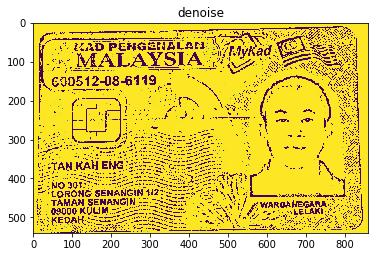

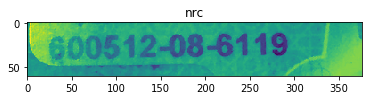

contours:  2


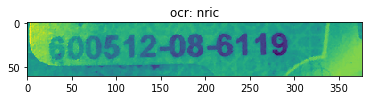

nric: . 500512-08-6119 —



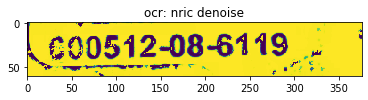

nric denoise: .£00512-08-6119 .



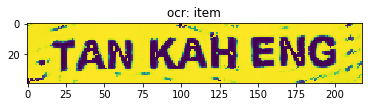

item: -TAN KAH ENG?



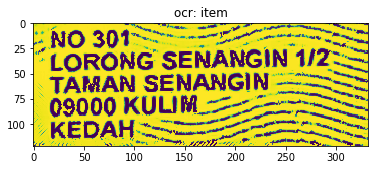

item: NO 3092S
LORONG SENANGIN 1/2=—=
i Ee

_ KEDAH see



In [291]:
img_file = '/home/williamkhoo/Desktop/projects/clean_data/ocr_test/028.jpg'
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
#image = hed_util.crop_image(net, image)
image = img_util.try_crop_image(image, threshold=0.3, iterations=3)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
img = cv2.resize(gray,(860,540),cv2.INTER_AREA)
#imshow(img, 'img')
denoise_img = denoise(img, base_kernel=25, scale=1, base_sigma=11, h=31)
imshow(denoise_img, 'denoise')
nric_box, name_address_box = get_nric_name_address(img)
nric = img[nric_box[1]:nric_box[3],nric_box[0]:nric_box[2]]
name_address = img[name_address_box[1]:name_address_box[3],name_address_box[0]:name_address_box[2]]
nric_denoise = denoise_img[nric_box[1]:nric_box[3],nric_box[0]:nric_box[2]]
name_address_denoise = denoise_img[name_address_box[1]:name_address_box[3],name_address_box[0]:name_address_box[2]]
imshow(nric,'nrc')
#imshow(name_address,'name_address')
na = split_name_and_address(name_address)
print('contours: ', len(na))
ocr_text_def(nric,'nric')
ocr_text(nric_denoise,'nric denoise')
for item in na:
    x, y, w, h = item
    #imshow(name_address_denoise[y:y+h,x:x+w],'card')
    ocr_text(name_address_denoise[y:y+h,x:x+w],'item')

#ocr_text(name_address,'name_address')


with base width,  860


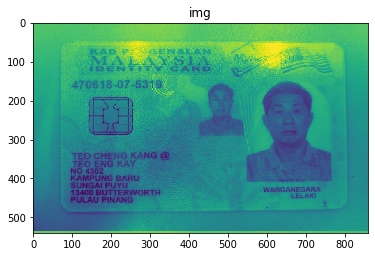

scale : 1


In [224]:
#img_file = os.path.join(TEST_IMAGE_PATH,'ocr/myhi00049.jpg')
img_file = '/home/williamkhoo/Desktop/projects/clean_data/ocr_test/003.jpg'
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
#image = hed_util.crop_image(net, image)
image = img_util.try_crop_image(image, base_width=860, threshold=0.3, iterations=3)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
img = cv2.resize(gray,(860,540),cv2.INTER_AREA)
imshow(img, 'img')
scale = image.shape[1] // 860
scale = 2 if scale == 0 else scale
print('scale :', scale)

with base width,  860


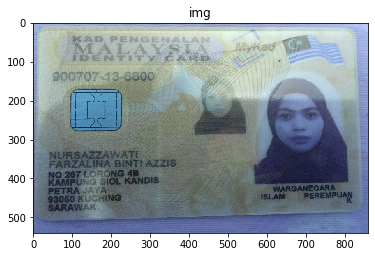

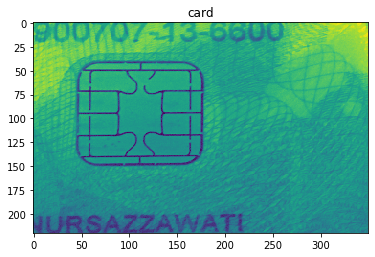

cx: 49, cy: 51, cw: 130, ch: 99


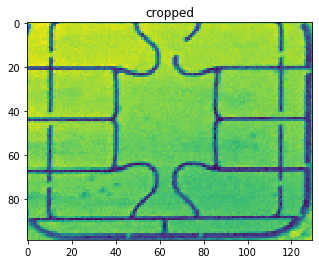

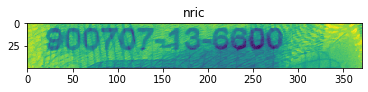

cx: 105, cy: 44, cw: 35, ch: 6
cx: 5, cy: 2, cw: 294, ch: 33


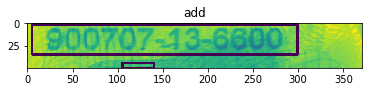

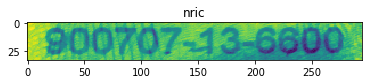

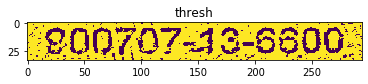

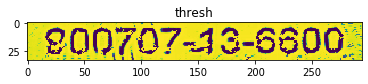

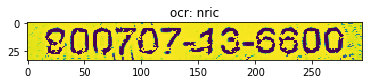

nric: 200707-~43-S300-



In [285]:
#img_file = '/home/williamkhoo/Desktop/projects/clean_data/my_id/1289596831709327361.jpg'
img_file = '/home/williamkhoo/Desktop/projects/clean_data/ocr_test/002.jpg'
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
image = img_util.try_crop_image(image, base_width=860, threshold=0.3, iterations=3)
img = cv2.resize(image,(860,540),cv2.INTER_AREA)
#card = img[0:330,0:300]
imshow(img, 'img')
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#imshow(gray, 'gray')
y1 = 130
y2 = 350
x1 = 50
x2 = 400
card = gray[y1:y2,x1:x2]
imshow(card, 'card')
cx1,cy1,cw1,ch1 = detect_chip(card)
print('cx: {}, cy: {}, cw: {}, ch: {}'.format(cx1,cy1,cw1,ch1))
cropped = card[cy1:cy1+ch1,cx1:cx1+cw1]
imshow(cropped, 'cropped')
end_y = y1+cy1-10
x_start = x1+cx1-70
x_start = x_start if x_start > 0 else 0
add = gray[end_y-50:end_y, x_start:400]
add2 = add.copy()
imshow(add, 'nric')
blur = cv2.medianBlur(add,7)
thresh1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,11, 9)
#ret, thresh1 = cv2.threshold(thresh1, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) 
#ret, t = cv2.threshold(cropped, 150, 255, cv2.THRESH_BINARY) 
#imshow(thresh1, 'thresh1')
# Specify structure shape and kernel size.  
# Kernel size increases or decreases the area  
# of the rectangle to be detected. 
# A smaller value like (10, 10) will detect  
# each word instead of a sentence. 
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (35, 11)) 
  
# Appplying dilation on the threshold image 
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 
#imshow(dilation, 'dilation')
cnts = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
contours = []
last_cnt = None
max_area = x = y = w = h = 0

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    print('cx: {}, cy: {}, cw: {}, ch: {}'.format(x,y,w,h))
    cv2.rectangle(add2, (x, y), (x + w, y + h), (0, 255, 0), 2)  

imshow(add2, 'add')  
nric = add[y:y+h,x:x+w]
imshow(nric, 'nric') 
thresh = cv2.adaptiveThreshold(nric,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,13, 7)
imshow(thresh,'thresh')
thresh = cv2.fastNlMeansDenoising(thresh, None, 49, 7, 27) 
imshow(thresh,'thresh')
#denoise_n = nric_denoise(nric)
ocr_text_def(thresh,'nric')


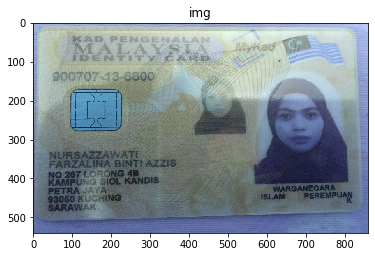

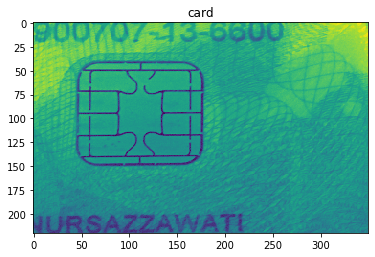

cx: 49, cy: 51, cw: 130, ch: 99


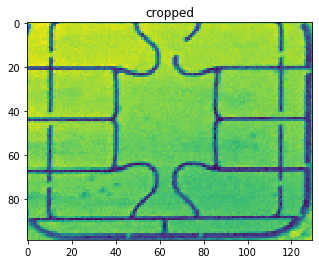

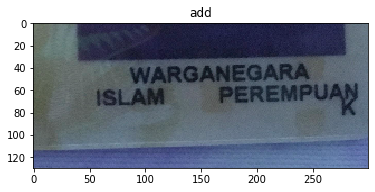

In [69]:
img_file = os.path.join(TEST_IMAGE_PATH,'(9)00464.jpg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
image = img_util.try_crop_image(image, threshold=0.3, iterations=3)
img = cv2.resize(image,(860,540),cv2.INTER_AREA)
#card = img[0:330,0:300]
imshow(img, 'img')
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#imshow(gray, 'gray')
y1 = 130
y2 = 350
x1 = 50
x2 = 400
card = gray[y1:y2,x1:x2]
imshow(card, 'card')
cx1,cy1,cw1,ch1 = detect_chip(card)
print('cx: {}, cy: {}, cw: {}, ch: {}'.format(cx1,cy1,cw1,ch1))
cropped = card[cy1:cy1+ch1,cx1:cx1+cw1]
imshow(cropped, 'cropped')
y_start = y1+cy1+ch1
x_start = x1+cx1-70
x_start = x_start if x_start > 0 else 0
add = img[y_start+100:y_start+230, x_start+500:x_start+800]
imshow(add, 'add')

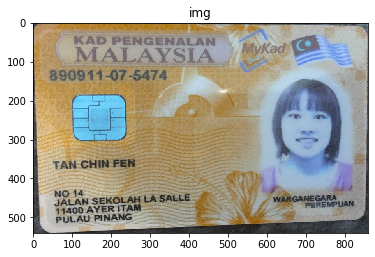

cx: 48, cy: 54, cw: 143, ch: 124
1.0163934426229508


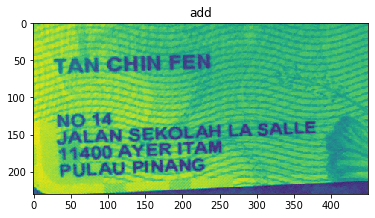

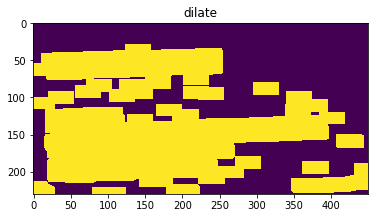

cx: 347, cy: 189, cw: 103, ch: 40
cx: 0, cy: 92, cw: 419, ch: 138
cx: 0, cy: 30, cw: 255, ch: 77


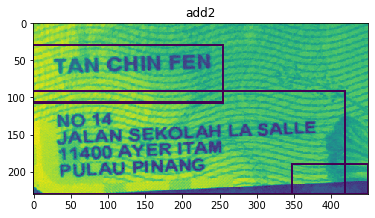

In [93]:
#img_file = os.path.join(TEST_IMAGE_PATH,'(9)00427.jpg')
img_file = '/home/williamkhoo/Desktop/projects/clean_data/ocr_test/021.jpg'
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
image = img_util.try_crop_image(image, threshold=0.3, iterations=3)
height_scale, width_scale = getScale(image)
#print('image scale ', width_scale)
img = cv2.resize(image,(860,540),cv2.INTER_AREA)
#card = img[0:330,0:300]
imshow(img, 'img')
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
standard_chip_height = 122
#imshow(gray, 'gray')
y1 = 130
y2 = 350
x1 = 50
x2 = 400
card = gray[y1:y2,x1:x2]
#imshow(card, 'card')
cx1,cy1,cw1,ch1 = detect_chip(card)
print('cx: {}, cy: {}, cw: {}, ch: {}'.format(cx1,cy1,cw1,ch1))
cropped = card[cy1:cy1+ch1,cx1:cx1+cw1]
print(ch1/standard_chip_height)
#imshow(cropped, 'cropped')
y_start = y1+cy1+ch1
x_start = x1+cx1-75
x_start = x_start if x_start > 0 else 0
add = gray[y_start:y_start+230, x_start:x_start+450]
add2 = add.copy()
add3 = add.copy()
imshow(add, 'add')
blur = cv2.GaussianBlur(add2, (15,15), 0)
#imshow(blur, 'blur')
sharpen = img_util.sharpen(blur)
#imshow(sharpen, 'sharpen')
thresh = cv2.adaptiveThreshold(sharpen,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,15,13)
#imshow(thresh, 'thresh')
thresh = cv2.fastNlMeansDenoising(thresh, None, 11,7,21)

# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,1))
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(thresh, [c], -1, 0, 3)

# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,15))
detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(thresh, [c], -1, 0, 3)
#imshow(thresh, 'remove lines')    
#thresh = cv2.fastNlMeansDenoising(thresh, None, 51,7,31)
#imshow(thresh, 'thresh')
# Dilate to combine adjacent text contours
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (35,21))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (35,17))
dilate = cv2.dilate(thresh, kernel, iterations=1)
imshow(dilate, 'dilate')

cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
contours = []
last_cnt = None
max_area = x = y = w = h = 0

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    if w >= 100 and h >= 30:
      print('cx: {}, cy: {}, cw: {}, ch: {}'.format(x,y,w,h))
      cv2.rectangle(add2, (x, y), (x + w, y + h), (0, 255, 0), 2)  
    if area > max_area:
      x1, y1, w1, h1 = cv2.boundingRect(c)  
      max_area = area
        
imshow(add2,'add2')  
nameAddress = add[y1:y1+h1,x1:x1+w1]

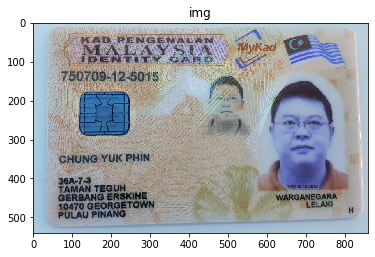

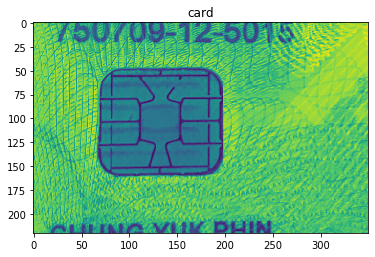

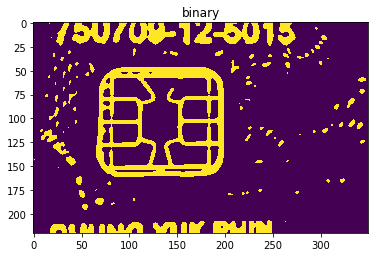

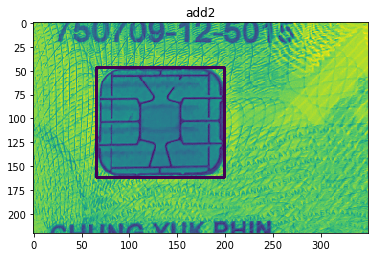

In [131]:
#img_file = '/home/williamkhoo/Desktop/projects/clean_data/my_id/1289066485393715202.jpeg'
img_file = '/home/williamkhoo/Desktop/projects/clean_data/ocr_test/026.jpg'
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
image = img_util.try_crop_image(image, base_width=860, threshold=0.25, iterations=3)
img = cv2.resize(image,(860,540),cv2.INTER_AREA)
#card = img[0:330,0:300]
imshow(img, 'img')
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
#imshow(gray, 'gray')
y1 = 130
y2 = 350
x1 = 50
x2 = 400
card = gray[y1:y2,x1:x2]
add2 = card.copy()
imshow(card, 'card')
denoise = ocr_util.denoise(card,base_kernel=25, scale=2, base_sigma=7)
blur = cv2.GaussianBlur(denoise, (9,9), 0)
binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]    
imshow(binary, 'binary')   
cnts,_ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(cnts, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(cnt)   
cv2.rectangle(add2, (x, y), (x + w, y + h), (0, 255, 0), 2) 
imshow(add2, 'add2')